## In this notebook we load the evaluation results from the models and compute the average of BLEU scores

In [1]:
# Importing libraries
import json
import pandas as pd
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import os
from configuration import Configuration
from configuration import CONSTANTS as C
# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction
from rich.table import Column, Table
from rich import box
from rich.console import Console
from tensorboardX import SummaryWriter
import time
from torch import cuda
import glob
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:


class YourDataSetClass(Dataset):
    """
    Creating a custom dataset for reading the dataset and 
    loading it into the dataloader to pass it to the neural network for finetuning the model
    """    
    def __init__(self, dataframe, tokenizer, source_len, target_len,answer_len, source_text, target_text,answer_text):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = target_len
        self.ans_len = answer_len
        self.target_text = self.data[target_text]
        self.source_text = self.data[source_text]
        self.answer_text = self.data[answer_text]

    def __len__(self):
        return len(self.target_text)

    def __getitem__(self, index):
        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])
        answer_text = str(self.answer_text[index])
        #cleaning data so as to ensure data is in string type
        source_text = ' '.join(source_text.split())
        target_text = ' '.join(target_text.split())
        answer_text = ' '.join(answer_text.split())
        source = self.tokenizer.batch_encode_plus([source_text], max_length= self.source_len, pad_to_max_length=True, truncation=True, padding="max_length", return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([target_text], max_length= self.summ_len, pad_to_max_length=True, truncation=True, padding="max_length", return_tensors='pt')
        answer = self.tokenizer.batch_encode_plus([answer_text], max_length= self.ans_len, pad_to_max_length=True, truncation=True, padding="max_length", return_tensors='pt')
        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()
        answer_ids = answer['input_ids'].squeeze()
        answer_mask = answer['attention_mask'].squeeze()
        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long),
            'answer_ids': answer_ids.to(dtype=torch.long),
            'answer_mask': answer_mask.to(dtype=torch.long)
        }


def create_model_dir(experiment_main_dir, experiment_id, model_summary):
    """
    Create a new model directory.
    :param experiment_main_dir: Where all experiments are stored.
    :param experiment_id: The ID of this experiment.
    :param model_summary: A summary string of the model.
    :return: A directory where we can store model logs. Raises an exception if the model directory already exists.
    """
    model_name = "{}-{}".format(experiment_id, model_summary)
    model_dir = os.path.join(experiment_main_dir, model_name)
    if os.path.exists(model_dir):
        raise ValueError("Model directory already exists {}".format(model_dir))
    os.makedirs(model_dir)
    return model_dir

def train(epoch, tokenizer, model, device, loader, optimizer,writer,global_step,records,model_dir):

    """
    Function to be called for training with the parameters passed from main function

    """
    model.train()
    c=0
    for _,data in enumerate(loader, 0):
        print("mem",torch.cuda.memory_allocated(device=C.DEVICE))
        c=c+1
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)
        
        ans_str = data['answer_ids'].to(device, dtype = torch.long)
        ans_mask = data['answer_mask'].to(device, dtype = torch.long)
        
        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids,
                        labels=lm_labels,answer_str=ans_str,answer_mask=ans_mask,tokenizer=tokenizer,c=c)
        loss = outputs[0]
        
        #print("preds",outputs["pred_ids"])
        #preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in outputs["pred_ids"]]
        #print(preds)
        #print("ans",outputs["ans_ids"])
        #an = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in outputs["ans_ids"]]
        #print(an)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        writer.add_scalar("loss", loss, global_step)
        
        
        ### measure bleu
        if c%10==0:
            model.eval()
            predictions = []
            actuals = []
            num_dist=[]
            ##outputs = model.generate(input_ids=input_ids, num_beams=5, num_return_sequences=3)
            generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=150, 
              num_beams=3,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True,
            num_return_sequences=3,
              )
            print(generated_ids.shape)
            print(generated_ids)
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=False)for t in y]
            print(preds)
            print(target)
            predictions.extend(preds)
            for tt in target:
                print(tt)
                actuals.extend([tt,tt,tt])
                num_dist.extend([1,2,3])
                print("actualslen",len(actuals))
                print(actuals)
            print(len(actuals))
            print(len(predictions))
            print(num_dist)
            temp_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals,'Num distractor':num_dist})
            print(temp_df.head())
            val=records.rename(columns={'distractor':'Actual Text'})

            gen_dist=val.merge(temp_df,on=['Actual Text']).loc[:,['text','Generated Text','Num distractor']]

            distractors=val.groupby(['text']).agg({ 'Actual Text': lambda x: list(x.str.split())}).reset_index()

            dist_compare=distractors.merge(gen_dist,on=['text'])
            dist_compare['Generated Text']=dist_compare['Generated Text'].str.split()
            dist_compare=dist_compare.assign(bleu1=dist_compare.apply(lambda x:sentence_bleu(x['Actual Text'],x['Generated Text'],weights=(1, 0, 0, 0),smoothing_function=SmoothingFunction().method1),axis=1))
            dist_compare=dist_compare.assign(bleu2=dist_compare.apply(lambda x:sentence_bleu(x['Actual Text'],x['Generated Text'],weights=(0, 1, 0, 0),smoothing_function=SmoothingFunction().method1),axis=1))
            dist_compare=dist_compare.assign(bleu3=dist_compare.apply(lambda x:sentence_bleu(x['Actual Text'],x['Generated Text'],weights=(0, 0, 1, 0),smoothing_function=SmoothingFunction().method1),axis=1))
            dist_compare=dist_compare.assign(bleu4=dist_compare.apply(lambda x:sentence_bleu(x['Actual Text'],x['Generated Text'],weights=(0, 0, 0, 1),smoothing_function=SmoothingFunction().method1),axis=1))
            
            for i in range(1,4):
                bleu_1=dist_compare.loc[dist_compare['Num distractor']==i].bleu1.mean()
                bleu_2=dist_compare.loc[dist_compare['Num distractor']==i].bleu2.mean()
                bleu_3=dist_compare.loc[dist_compare['Num distractor']==i].bleu3.mean()
                bleu_4=dist_compare.loc[dist_compare['Num distractor']==i].bleu4.mean()
                writer.add_scalar('bleu/distractor_{}/bleu_1'.format(i), bleu_1, global_step)
                writer.add_scalar('bleu/distractor_{}/bleu_2'.format(i), bleu_2, global_step)
                writer.add_scalar('bleu/distractor_{}/bleu_3'.format(i), bleu_3, global_step)
                writer.add_scalar('bleu/distractor_{}/bleu_4'.format(i), bleu_4, global_step)
            
            
            bleu_1=dist_compare.bleu1.mean()
            bleu_2=dist_compare.bleu2.mean()
            bleu_3=dist_compare.bleu3.mean()
            bleu_4=dist_compare.bleu4.mean()
            writer.add_scalar("bleu/distractor_gen/bleu_1", bleu_1, global_step)
            writer.add_scalar("bleu/distractor_gen/bleu_2", bleu_2, global_step)
            writer.add_scalar("bleu/distractor_gen/bleu_3", bleu_3, global_step)
            writer.add_scalar("bleu/distractor_gen/bleu_4", bleu_4, global_step)
            
            if c%1000==0:
                path = os.path.join(model_dir, "model_files")
                model.save_pretrained(path)
                tokenizer.save_pretrained(path)

            model.train()

        
        
        global_step += 1
    return global_step



In [3]:
def validate(epoch, tokenizer, model, device, loader,writer):

    """
    Function to evaluate model for predictions

    """
    global_step = 0
    model.eval()
    predictions = []
    actuals = []
    num_dist=[]
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)
            generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=150, 
              num_beams=3,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True,
                num_return_sequences=3,
              )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=False)for t in y]
            predictions.extend(preds)
            for tt in target:
                actuals.extend([tt,tt,tt])
                num_dist.extend([1,2,3])

        temp_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals,'Num distractor':num_dist})
        val=records.rename(columns={'distractor':'Actual Text'})

        gen_dist=val.merge(temp_df,on=['Actual Text']).loc[:,['text','Generated Text','Num distractor']]

        distractors=val.groupby(['text']).agg({ 'Actual Text': lambda x: list(x.str.split())}).reset_index()

        dist_compare=distractors.merge(gen_dist,on=['text'])
        dist_compare['Generated Text']=dist_compare['Generated Text'].str.split()
        dist_compare=dist_compare.assign(bleu1=dist_compare.apply(lambda x:sentence_bleu(x['Actual Text'],x['Generated Text'],weights=(1, 0, 0, 0),smoothing_function=SmoothingFunction().method1),axis=1))
        dist_compare=dist_compare.assign(bleu2=dist_compare.apply(lambda x:sentence_bleu(x['Actual Text'],x['Generated Text'],weights=(0, 1, 0, 0),smoothing_function=SmoothingFunction().method1),axis=1))
        dist_compare=dist_compare.assign(bleu3=dist_compare.apply(lambda x:sentence_bleu(x['Actual Text'],x['Generated Text'],weights=(0, 0, 1, 0),smoothing_function=SmoothingFunction().method1),axis=1))
        dist_compare=dist_compare.assign(bleu4=dist_compare.apply(lambda x:sentence_bleu(x['Actual Text'],x['Generated Text'],weights=(0, 0, 0, 1),smoothing_function=SmoothingFunction().method1),axis=1))

        for i in range(1,4):
            bleu_1=dist_compare.loc[dist_compare['Num distractor']==i].bleu1.mean()
            bleu_2=dist_compare.loc[dist_compare['Num distractor']==i].bleu2.mean()
            bleu_3=dist_compare.loc[dist_compare['Num distractor']==i].bleu3.mean()
            bleu_4=dist_compare.loc[dist_compare['Num distractor']==i].bleu4.mean()
            writer.add_scalar('val/bleu/distractor_{}/bleu_1'.format(i), bleu_1, global_step)
            writer.add_scalar('val/bleu/distractor_{}/bleu_2'.format(i), bleu_2, global_step)
            writer.add_scalar('val/bleu/distractor_{}/bleu_3'.format(i), bleu_3, global_step)
            writer.add_scalar('val/bleu/distractor_{}/bleu_4'.format(i), bleu_4, global_step)


        bleu_1=dist_compare.bleu1.mean()
        bleu_2=dist_compare.bleu2.mean()
        bleu_3=dist_compare.bleu3.mean()
        bleu_4=dist_compare.bleu4.mean()
        writer.add_scalar("val/bleu/distractor_gen/bleu_1", bleu_1, global_step)
        writer.add_scalar("val/bleu/distractor_gen/bleu_2", bleu_2, global_step)
        writer.add_scalar("val/bleu/distractor_gen/bleu_3", bleu_3, global_step)
        writer.add_scalar("val/bleu/distractor_gen/bleu_4", bleu_4, global_step)
            
    return predictions, actuals



In [5]:
def get_model_dir(experiment_dir, model_id):
    """Return the directory in `experiment_dir` that contains the given `model_id` string."""
    model_dir = glob.glob(os.path.join(experiment_dir, str(model_id) + "-*"), recursive=False)
    return None if len(model_dir) == 0 else model_dir[0]

def get_model_config(model_id):
    model_id = model_id
    model_dir = get_model_dir(os.path.join(C.DATA_DIR, "experiments/"), model_id)
    model_config = 0#Configuration.from_json(os.path.join(model_dir, 'config.json'))
    return model_config, model_dir

def load_model(model_id):
    model_config, model_dir = get_model_config(model_id)
    path = os.path.join(model_dir, "model_files")
    tokenizer = T5Tokenizer.from_pretrained(path)

    model = T5ForConditionalGeneration.from_pretrained(path)

    model.to(C.DEVICE)

    return model,tokenizer, model_config, model_dir

In [4]:

model_params={
    "MODEL":"t5-small",             # model_type: t5-base/t5-large
    "TRAIN_BATCH_SIZE":2,          # training batch size
    "VALID_BATCH_SIZE":2,          # validation batch size
    "TRAIN_EPOCHS":2,              # number of training epochs
    "VAL_EPOCHS":1,                # number of validation epochs
    "LEARNING_RATE":1e-4,          # learning rate
    "MAX_SOURCE_TEXT_LENGTH":900,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH":901,   # max length of target text
    "MAX_ANSWER_LENGTH":900,   # max length of answer text
    "SEED": 42                     # set seed for reproducibility 

}


source_text='text'
target_text='distractor'
answer_text='answer_text'
model_params=model_params

with open(os.path.join(C.DATA_DIR, "distractor/race_train_original.json"), 'r') as content_file:
    content = content_file.read()
content=content.replace('\n',',')
content='['+content[:-1]+']'
records = json.loads(content)
records=pd.DataFrame(records)

# Set random seeds and deterministic pytorch for reproducibility
torch.manual_seed(model_params["SEED"]) # pytorch random seed
np.random.seed(model_params["SEED"]) # numpy random seed
torch.backends.cudnn.deterministic = True


# tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])

# Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary. 
# Further this model is sent to device (GPU/TPU) for using the hardware.
model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
model = model.to(C.DEVICE)

## format the input
records=records.assign(question=records.question.str.join(' '))
records=records.assign(distractor=records.distractor.str.join(' '))
records=records.assign(article=records.article.str.join(' '))
records=records.assign(answer_text=records.answer_text.str.join(' '))
records=records.loc[:,['article','question','answer_text','distractor']]
records=records.assign(text="dist q: "+records.question+" a: "+records.answer_text+" p: "+records.article)
records=records.loc[:,['text','distractor','answer_text']]

with open(os.path.join(C.DATA_DIR, "distractor/race_dev_original.json"), 'r') as content_file:
    content = content_file.read()
content=content.replace('\n',',')
content='['+content[:-1]+']'
records_test = json.loads(content)
records_test=pd.DataFrame(records_test)

## format the input
records_test=records_test.assign(question=records_test.question.str.join(' '))
records_test=records_test.assign(distractor=records_test.distractor.str.join(' '))
records_test=records_test.assign(article=records_test.article.str.join(' '))
records_test=records_test.assign(answer_text=records_test.answer_text.str.join(' '))
records_test=records_test.loc[:,['article','question','answer_text','distractor']]
records_test=records_test.assign(text="dist q: "+records_test.question+" a: "+records_test.answer_text+" p: "+records_test.article)
records_test=records_test.loc[:,['text','distractor','answer_text']]

# Creation of Dataset and Dataloader
# Defining the train size. So 80% of the data will be used for training and the rest for validation. 
val_dataset=records_test
train_dataset = records


# Creating the Training and Validation dataset for further creation of Dataloader
training_set = YourDataSetClass(train_dataset, tokenizer, model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"],model_params["MAX_ANSWER_LENGTH"], source_text, target_text,answer_text)
val_set = YourDataSetClass(val_dataset, tokenizer, model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"],model_params["MAX_ANSWER_LENGTH"], source_text, target_text,answer_text)



# Defining the parameters for creation of dataloaders
train_params = {
  'batch_size': model_params["TRAIN_BATCH_SIZE"],
  'shuffle': True,
  'num_workers': 0
  }


val_params = {
  'batch_size': model_params["VALID_BATCH_SIZE"],
  'shuffle': False,
  'num_workers': 0
  }


# Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
training_loader = DataLoader(training_set, **train_params)
val_loader = DataLoader(val_set, **val_params)


# Defining the optimizer that will be used to tune the weights of the network in the training session. 
optimizer = torch.optim.Adam(params =  model.parameters(), lr=model_params["LEARNING_RATE"])

## RESULTS COSINE SIMILARITY

In [ ]:
1625497725    lambda 0.3 normal cosine
1625497726    lambda 0.4 normal cosine
1625497756    lambda 0.2 normal cosine
1625665307    lambda 0.1 normal cosine

In [6]:
## 1625497726 0.4
model,tokenizer, model_config, model_dir = load_model(1625497726)
final_df4=pd.read_csv(os.path.join(model_dir, 'predictions.csv'))
final_df4=final_df4.groupby(['Num distractor']).mean().reset_index()
final_df4=final_df4.assign(Lambda=0.4)
final_df4

,Num distractor,bleu1,bleu2,bleu3,bleu4,Lambda
0,1,0.253613,0.090932,0.051882,0.038624,0.4
1,2,0.246943,0.082840,0.046607,0.034424,0.4
2,3,0.195244,0.063403,0.033490,0.025785,0.4


In [7]:
## 1625497725 0.3
model,tokenizer, model_config, model_dir = load_model(1625497725)
final_df3=pd.read_csv(os.path.join(model_dir, 'predictions.csv'))
final_df3=final_df3.groupby(['Num distractor']).mean().reset_index()
final_df3=final_df3.assign(Lambda=0.3)
final_df3

,Num distractor,bleu1,bleu2,bleu3,bleu4,Lambda
0,1,0.254536,0.090609,0.051279,0.037286,0.3
1,2,0.248582,0.081285,0.043693,0.032288,0.3
2,3,0.184080,0.057492,0.030443,0.022425,0.3


In [8]:
## 1625497756 0.2
model,tokenizer, model_config, model_dir = load_model(1625497756)
final_df2=pd.read_csv(os.path.join(model_dir, 'predictions.csv'))
final_df2=final_df2.groupby(['Num distractor']).mean().reset_index()
final_df2=final_df2.assign(Lambda=0.2)
final_df2

,Num distractor,bleu1,bleu2,bleu3,bleu4,Lambda
0,1,0.237260,0.083794,0.047737,0.034073,0.2
1,2,0.242868,0.080669,0.044823,0.033270,0.2
2,3,0.200969,0.065399,0.035270,0.026071,0.2


In [9]:
# 1625665307 0.1
model,tokenizer, model_config, model_dir = load_model(1625665307)
final_df1=pd.read_csv(os.path.join(model_dir, 'predictions.csv'))
final_df1=final_df1.groupby(['Num distractor']).mean().reset_index()
final_df1=final_df1.assign(Lambda=0.1)
final_df1

,Num distractor,bleu1,bleu2,bleu3,bleu4,Lambda
0,1,0.230350,0.082875,0.048152,0.034500,0.1
1,2,0.251306,0.086232,0.047511,0.035110,0.1
2,3,0.212373,0.070870,0.038128,0.028427,0.1


## Plot different lambda values

In [10]:
dfs=pd.concat([final_df1,final_df2,final_df3,final_df4])

In [11]:
dfs

,Num distractor,bleu1,bleu2,bleu3,bleu4,Lambda
0,1,0.230350,0.082875,0.048152,0.034500,0.1
1,2,0.251306,0.086232,0.047511,0.035110,0.1
2,3,0.212373,0.070870,0.038128,0.028427,0.1
0,1,0.237260,0.083794,0.047737,0.034073,0.2
1,2,0.242868,0.080669,0.044823,0.033270,0.2
2,3,0.200969,0.065399,0.035270,0.026071,0.2
0,1,0.254536,0.090609,0.051279,0.037286,0.3
1,2,0.248582,0.081285,0.043693,0.032288,0.3
2,3,0.184080,0.057492,0.030443,0.022425,0.3
0,1,0.253613,0.090932,0.051882,0.038624,0.4


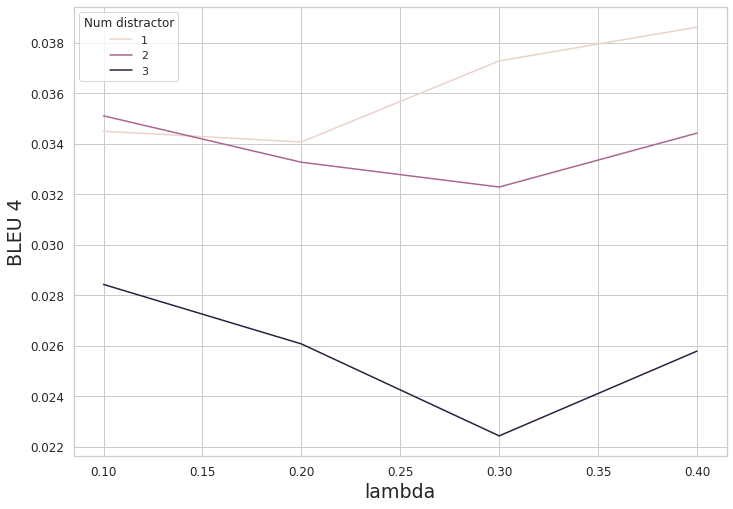

In [24]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.set(palette="tab10", color_codes=True)

sns.set_style("whitegrid")

ax=sns.lineplot(data=dfs, x="Lambda", y="bleu4",hue='Num distractor')
plt.xlabel('lambda', fontsize=19)
plt.ylabel('BLEU 4', fontsize=19)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
#plt.legend( prop={'size': 15})

## second term

In [ ]:
1625737264    lambda 0.1 cossim
1625754955    lambda 0.3 cossim
1625986733    lambda 0.2 cossim
1625986969    lambda 0.4 cossim

In [12]:
## 1625737264 0.1
final_df.groupby(['Num distractor']).mean()

,bleu1,bleu2,bleu3,bleu4
Num distractor,,,,
1,0.183450,0.065138,0.038547,0.028810
2,0.231636,0.075846,0.041913,0.031878
3,0.190971,0.059853,0.034012,0.027023


In [15]:
## 1625754955 0.3
final_df.groupby(['Num distractor']).mean()

,bleu1,bleu2,bleu3,bleu4
Num distractor,,,,
1,0.191715,0.065558,0.038184,0.029138
2,0.230328,0.074695,0.042564,0.033427
3,0.183205,0.056311,0.032210,0.025544


In [ ]:
## 1625986733 0.2
final_df.groupby(['Num distractor']).mean()

In [ ]:
# 1625986969 0.4
final_df.groupby(['Num distractor']).mean()

## new dataset cos

In [ ]:
1626187137    lambda 0.1 normal cosine new data
1626187143    lambda 0.2 normal cosine new data
1626187168    lambda 0.4 normal cosine new data
1626208898    lambda 0.3 normal cosine new data

In [ ]:
## 1626187137 0.1
final_df.groupby(['Num distractor']).mean()

In [11]:
## 1626187143 0.2
final_df.groupby(['Num distractor']).mean()

,bleu1,bleu2,bleu3,bleu4
Num distractor,,,,
1,0.128280,0.043747,0.024714,0.018556
2,0.168690,0.057115,0.032223,0.024864
3,0.121257,0.039501,0.021004,0.016721


In [8]:
## 1626187168 0.4
final_df.groupby(['Num distractor']).mean()

,bleu1,bleu2,bleu3,bleu4
Num distractor,,,,
1,0.113394,0.039441,0.022793,0.016696
2,0.154270,0.051126,0.028429,0.022201
3,0.105161,0.032854,0.016768,0.013299


In [ ]:
# 1626208898 0.3
final_df.groupby(['Num distractor']).mean()

## small t5 no parameter

In [9]:
# 1626248527 no param
model,tokenizer, model_config, model_dir = load_model(1626248527)
final_df1=pd.read_csv(os.path.join(model_dir, 'predictions_test.csv'))
final_df1=final_df1.groupby(['Num distractor']).mean().reset_index()
final_df1=final_df1.assign(Lambda=0)
final_df1

,Num distractor,bleu1,bleu2,bleu3,bleu4,Lambda
0,1,0.125167,0.039880,0.024022,0.019474,0
1,2,0.147106,0.041797,0.024307,0.020742,0
2,3,0.126151,0.037170,0.021399,0.018778,0


In [39]:
# 1626248527 no param
model,tokenizer, model_config, model_dir = load_model(1626248527)
final_df1=pd.read_csv(os.path.join(model_dir, 'predictions.csv'))
final_df1=final_df1.groupby(['Num distractor']).mean().reset_index()
final_df1=final_df1.assign(Lambda=0)
final_df1

,Num distractor,bleu1,bleu2,bleu3,bleu4,Lambda
0,1,0.213585,0.076613,0.043997,0.031741,0
1,2,0.243437,0.080335,0.045028,0.034469,0
2,3,0.204719,0.067339,0.036658,0.028370,0


In [26]:
## 1625497726 0.4
model,tokenizer, model_config, model_dir = load_model(1624812313)
final_df4=pd.read_csv(os.path.join(model_dir, 'predictions_test.csv'))
final_df4=final_df4.groupby(['Num distractor']).mean().reset_index()
final_df4=final_df4.assign(Lambda=0.4)
final_df4

,Num distractor,bleu1,bleu2,bleu3,bleu4,Lambda
0,1,0.157793,0.047474,0.028002,0.022827,0.4
1,2,0.155504,0.045625,0.026504,0.022010,0.4
2,3,0.129866,0.037152,0.021090,0.017905,0.4


## base

In [41]:
model_dir = get_model_dir(os.path.join(C.DATA_DIR, "experiments/"), 1625154455)
final_df1=pd.read_csv(os.path.join(model_dir, 'predictions.csv'))
final_df1=final_df1.groupby(['Num distractor']).mean().reset_index()
final_df1=final_df1.assign(Lambda=0)
final_df1

,Num distractor,bleu1,bleu2,bleu3,bleu4,Lambda
0,1,0.291432,0.117174,0.069711,0.050688,0
1,2,0.301844,0.112849,0.063787,0.046634,0
2,3,0.267000,0.094754,0.052004,0.038210,0


## other

In [ ]:
model_dir = get_model_dir(os.path.join(C.DATA_DIR, "experiments/"), 1624812313)
final_df1=pd.read_csv(os.path.join(model_dir, 'predictions_test.csv'))
final_df1=final_df1.groupby(['Num distractor']).mean().reset_index()
final_df1=final_df1.assign(Lambda=0)
final_df1

## similarity with answer

In [75]:
## 1625497726 0.4
model,tokenizer, model_config, model_dir = load_model(1625497726)
final_df4=pd.read_csv(os.path.join(model_dir, 'predictions.csv'),converters={"Generated Text":  lambda x: x.strip("[]").replace("'","").split(", ")})

In [76]:
# 1626248527 no param
model,tokenizer, model_config, model_dir = load_model(1626248527)
final_df1=pd.read_csv(os.path.join(model_dir, 'predictions.csv'),converters={"Generated Text":  lambda x: x.strip("[]").replace("'","").split(", ")})

In [39]:
## 1625497726 0.4
model,tokenizer, model_config, model_dir = load_model(1625497726)
final_df4=pd.read_csv(os.path.join(model_dir, 'predictions.csv'),converters={"Generated Text":  lambda x: x.strip("[]").replace("'","").replace(",","")})

In [40]:
# 1626248527 no param
model,tokenizer, model_config, model_dir = load_model(1626248527)
final_df1=pd.read_csv(os.path.join(model_dir, 'predictions.csv'),converters={"Generated Text":  lambda x: x.strip("[]").replace("'","").replace(",","")})

In [41]:
final_df1.dtypes

text               object
Actual Text        object
Generated Text     object
Num distractor      int64
bleu1             float64
bleu2             float64
bleu3             float64
bleu4             float64
dtype: object

In [42]:
records_test_ans=records_test.loc[:,['text','answer_text']].drop_duplicates()

In [43]:
final_df1=final_df1.merge(records_test_ans,on=['text'])

final_df4=final_df4.merge(records_test_ans,on=['text'])

In [47]:
final_df1=final_df1[final_df1['Generated Text']!='.']
final_df4=final_df4[final_df4['Generated Text']!='.']

In [48]:
final_df1['answer_text']=final_df1['answer_text'].str.split()

final_df4['answer_text']=final_df4['answer_text'].str.split()

In [49]:
final_df1['Generated Text']=final_df1['Generated Text'].str.split()

final_df4['Generated Text']=final_df4['Generated Text'].str.split()

In [50]:
final_df1['Generated Text']=final_df1['Generated Text'].apply(lambda x:list(x))

final_df4['Generated Text']=final_df4['Generated Text'].apply(lambda x:list(x))

In [52]:
b4=final_df1.apply(lambda x:sentence_bleu(x['answer_text'],x['Generated Text'],weights=(0, 0, 0, 1),smoothing_function=SmoothingFunction().method1),axis=1)
b3=final_df1.apply(lambda x:sentence_bleu(x['answer_text'],x['Generated Text'],weights=(0, 0, 1, 0),smoothing_function=SmoothingFunction().method1),axis=1)
b2=final_df1.apply(lambda x:sentence_bleu(x['answer_text'],x['Generated Text'],weights=(0, 1, 0, 0),smoothing_function=SmoothingFunction().method1),axis=1)
final_df1=final_df1.assign(bleu4_ans=b4)
final_df1=final_df1.assign(bleu3_ans=b3)
final_df1=final_df1.assign(bleu2_ans=b2)

In [53]:
b4=final_df4.apply(lambda x:sentence_bleu(x['answer_text'],x['Generated Text'],weights=(0, 0, 0, 1),smoothing_function=SmoothingFunction().method1),axis=1)
b3=final_df4.apply(lambda x:sentence_bleu(x['answer_text'],x['Generated Text'],weights=(0, 0, 1, 0),smoothing_function=SmoothingFunction().method1),axis=1)
b2=final_df4.apply(lambda x:sentence_bleu(x['answer_text'],x['Generated Text'],weights=(0, 1, 0, 0),smoothing_function=SmoothingFunction().method1),axis=1)
final_df4=final_df4.assign(bleu4_ans=b4)
final_df4=final_df4.assign(bleu3_ans=b3)
final_df4=final_df4.assign(bleu2_ans=b2)